# **Reverse Engineering the Mechanism of WeChat Red Envelope**

In our project, we try to reverse-engineer the random allocation mechanism of WeChat Red Envelope, which is known as the WRE. We devide our project into following steps:
1. **Observation**: including data processing and obtain an intuitively speaking of our collected data
2. **Modeling**: from data we've collected, we find the regularity inside it and design our own model based on implicit assumptions
3. **Validation**: we use the model we've designed and simulate the large number of envelopes, to validate that our model has a similar performance to the true data microscropically
4. **Decision Making**: based on our model designed, find out the better or best strategy when to grab an envelope
5. **Further exploration**: we additionally come up with ideas of some interesting things and try to give some strategy or solution to it

In [49]:
from read_csv import *
import numpy as np
import matplotlib.pyplot as plt

## ***1.Observation***

When collecting data, we set our $3$ experiment settings as follows:
|number of people|money of envelope|experiment times|
| --- | --- | --- |
|$5$|$20$|$100$|
|$10$|$2.5$|$10$|
|$20$|$5$|$12$|

Among them, groups of $10$ and $20$ people are used as validation sets.

In order to avoid factors like network delay, mobile phone model and other influencing issues as possible, we adopted different orders of grabbing red packets, which means, every $20$ times we change our grabbing sequence. Since we only focus on the relation between sequence and grabbed money, this method won't affect the final result.

Our datas are collected in file *'database'*.

In [50]:
# read the data and store them in numpy arrays
data05 = read_csv05('database/data05.csv')
data10 = read_csv10('database/data10.csv')
data20 = read_csv20('database/data20.csv')
print(data05.shape)
print(data10.shape)
print(data20.shape)

mean05 = np.mean(data05, axis=1)
mean10 = np.mean(data10, axis=1)
mean20 = np.mean(data20, axis=1)

data05_all = np.concatenate((data05[0], data05[1], data05[2], data05[3], data05[4]))


(5, 100)
(10, 10)
(20, 12)


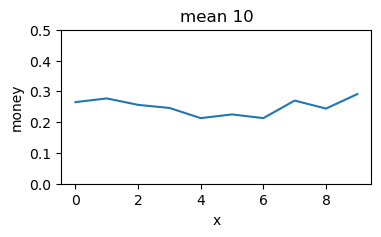

In [51]:
# As example of showing the data's correctness, we output the diagram of mean10
x = range(10)
plt.figure(figsize=(4,2))
plt.plot(x, mean10)
plt.title("mean 10")
plt.xlabel("x")
plt.ylabel("money")
plt.ylim(0, 0.5)
plt.show()

To have an intuitive view of the data, we draw a scatter plot based on the data of the group of five people including all of its data. On the figure, we also visualize the average mean of each data.

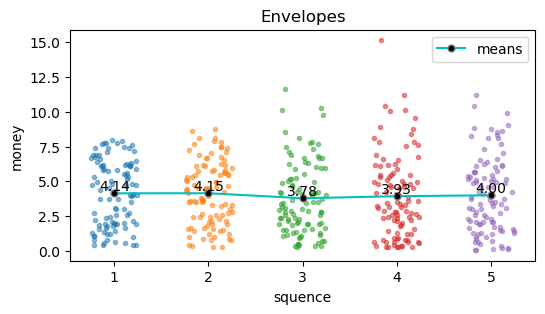

variance for each sqeuence:
[5.50708331 5.02952064 6.52382499 8.67529764 7.18975596]
standard deviation for each sqeuence:
[2.34671756 2.24265928 2.55417795 2.94538582 2.68137203]


In [52]:
plt.figure(figsize=(6,3))
for i in range(5):
    x = np.random.random(100)
    x = x / 2 + i + 0.75
    plt.scatter(x, data05[i], marker='.', alpha=0.5)
x_label = range(1, 6)
plt.plot(x_label,mean05,'c',label='means',markersize=5,markerfacecolor='black',marker='o',markeredgecolor='grey')
plt.xlabel("squence")
plt.ylabel("money")
plt.legend()
plt.title("Envelopes")
for i, j in zip(x_label, mean05):
    plt.text(i, j, '%.2f' % j, ha='center', va='bottom', fontsize=10)
plt.show()
print("variance for each sqeuence:")
print(np.var(data05, axis=1))
print("standard deviation for each sqeuence:")
print(np.std(data05, axis=1))

Intuitively, the person who grabs the envelope later is more likely to grab the bigger red envelope, but the person who grabs it first steals more on average. Besides, the latter graber also receives a more dispersed number of money, which can be shown from the ascending variance for each sequence.

We start with the first person to grab the red envelope and try to figure out how it's distributed. We compare the truth data with uniform distribution, normal distribution, exponential distribution, and binomial distribution. We randomly generate these four distributions with scale of $n=100$ and obtain their CDFs. Then we seperately draw them on the diagram and compare with the original data.

413.86999999999995


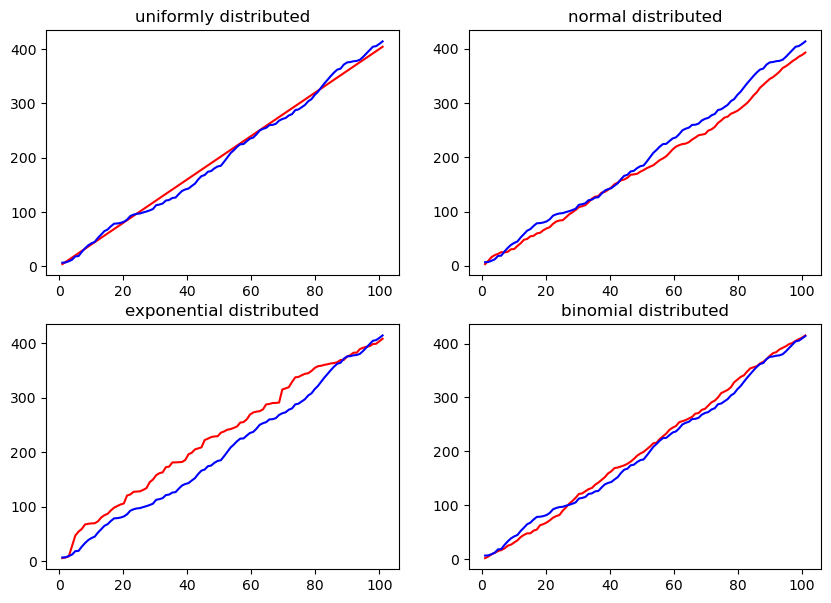

In [53]:
from find_distribution import *


data05_cdf0 = compute_cdf(data05[0])
print(data05_cdf0[99])


x_unif = np.linspace(1, 101, 100)
y_unif = x_unif * 4
# 2.3452 is obtained from sqrt of data05[0] variance
y_norm = np.random.normal(4, 2.3452, 100)
y_norm_cdf = compute_cdf(y_norm)
y_exp = np.random.exponential(4, 100)
y_exp_cdf = compute_cdf(y_exp)
y_binom = np.random.binomial(100, 0.04, 100)
y_binom_cdf = compute_cdf(y_binom)
plt.figure(figsize=(10, 7))
# uniformly distributed
plt.subplot(221)
plt.plot(x_unif, y_unif, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("uniformly distributed")
# normal distributed
plt.subplot(222)
plt.plot(x_unif, y_norm_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("normal distributed")
# exponential distributed
plt.subplot(223)
plt.plot(x_unif, y_exp_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("exponential distributed")
# binomial distributed
plt.subplot(224)
plt.plot(x_unif, y_binom_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("binomial distributed")
plt.show()

We set the sum of squared error as loss to compare the datas. Under this estimation, Uniform distribution is the distribution that fit our data most.

In [54]:
print("Loss of uniform distribution:", compute_loss(data05[0], np.zeros(100) + 4))
print("Loss of normal distribution:", compute_loss(data05[0], y_norm))
print("Loss of exponential distribution:", compute_loss(data05[0], y_exp))
print("Loss of binomial distribution:", compute_loss(data05[0], y_binom))

Loss of uniform distribution: 552.6321
Loss of normal distribution: 832.4440205637777
Loss of exponential distribution: 2422.68213176781
Loss of binomial distribution: 832.6320999999998


We can also use **KL divergence** to compare our approximate distributions. **KL divergence**, which is known as **Kullback-Leibler divergence**, is a method to measure the difference between two distributions through entropy.

Reference: \
*https://blog.csdn.net/qq_27782503/article/details/121830753*

In [55]:
print("KL divergence comparing uniform distribution:", KL_divergence(data05[0], np.zeros(100) + 4))
print("KL divergence comparing normal distribution:", KL_divergence(data05[0], y_norm))
print("KL divergence comparing exponential distribution:", KL_divergence(data05[0], y_exp))
print("KL divergence comparing binomial distribution:", KL_divergence(data05[0], y_binom))

KL divergence comparing uniform distribution: 0.18228341699566947
KL divergence comparing normal distribution: inf
KL divergence comparing exponential distribution: 0.6848844386116308
KL divergence comparing binomial distribution: inf


It is found that the information lost by uniform distribution is still smaller than that lost by the other three distributions.

Therefore, we can conclude tentatively that **the data is uniformly distributed**.

## ***2.Modeling***

Back to our collected data in part $1$, from the money that the first person grabbed, we surprisingly find out that this poor guy does not ever get a money bigger than $8$ yuan, and never grab an extremely big envelope like $10$ or $12$ yuan like the latter graber, in the total $100$ tries!

We notice that $8$ yuan happens coincidently to be the twice average of the remaining amout. So why not make a guess that the maximum amount of red packets each person can grab is twice the average of the remaining amount, and then try to prove it! 

***Proof upper limit is $2$ times the remaining average:***\
Since the data set conforms to a uniform distribution, the prior distribution chooses a conjugate **Pareto distribution**.
$$p(a) \sim P(b,K) = 
\begin{cases}
    \frac{Kb^K}{a^{K+1}} & \text{if } a \geq b\\
    0                    & otherwise
\end{cases}
$$

where $b$ is **the smallest possible value**, $a$ is **any number greater than $b$**, and $K$ is **a positive parameter**.\
\
This is an important property of the **Pareto distribution**, namely that its probability density function starts at $a = b$ and decreases when $a > b$. This density distribution function says that a must be greater than some constant $b$, but not too large, and $K$ is used to control how much is too large. In a **Pareto distribution**, the value of the parameter $K$ (the scaling parameter) determines the thickness of the "tail" of the distribution, that is, the frequency with which observations that are larger than the mean value $1$ occur. The smaller the value of $K$, the thicker the tail, that is, the more likely it is that large observations will occur.If $K\to 0$ and $b\to 0$,then there is no information.\
\
**The mean of this distribution** is
$$E(a) = \frac{Kb}{K-1}$$
Given a **Pareto prior**, the **joint distribution** of $a$ and $a$ dataset $D = {x_1, ..., x_N }$ is
$$p(D,a) = \frac{Kb^K}{a^{N+K+1}},a \geq max(D)$$
where $D$ represents **the data set** and $N$ represents **the size of the data set**.\
\
Let $m$ be the maximum value in $D$, then the evidence is
$$p(D) = \int_{-\infty}^{\infty} p(D,a)da = \int_m^{\infty}\frac{Kb^K}{a^{N+K+1}}da =
\begin{cases}
    \frac{K}{(N+K)b^N}, & \text{if } m \leq b\\
    \frac{Kb^K}{(N+K)m^{N+k}}, & \text{if } m > b\\
\end{cases}
$$
This function is the probability that all $N$ samples came from the same **uniform distribution**.\
The **posterior** for $a$ is
$$p(a|D) = \frac{p(D, a)}{p(D)} \sim Pa(c, N + K)$$
where $c = max(m, b)$
\
As we get more samples, we become more sure that a is not much greater than c.\
\
This analysis provides us with various answers to the ***"taxicab problem"***, where we must provide
an estimate for a given $D$ but no other information. Ignoring the fact that these are taxicabs,
we can use a noninformative prior to get $p(a|D) \sim P a(m, N)$. The mode of the posterior is $m$,
however this always underestimates the true value. The mean of the posterior, which minimizes
the expected squared error, is $\frac{Nm}{N−1}$, which doesn’t exist for $N = 1$.

We find the $CDF$ firstly,
$$Pr(max \leq m|a) = Pr(\text{all N samples} \leq m|a) = (\frac{m}{a})^N$$
From the $CDF$, we can find the $PDF$
$$p(m|a) = \frac{d}{dm}Pr(max \leq m|a) = \frac{N}{a}(\frac{m}{a})^{N-1}$$
Then, we will get the expectation
$$E(m) = E(m|a) = \int_{-\infty}^{\infty} mp(m|a)dm = \int_0^aN(\frac{m}{a})^Ndm = \frac{Na}{N+1}$$
So the **unbiased estimate of** $a$ is $\frac{(N+1)m}{N}$, For $N = 1$, the median and unbiased estimator agree on
$\hat{a} = 2m$. With a different prior, e.g. with $K = 1$, we get different answers. The mode is still $m$ but the posterior mean is $\frac{N+K}
{N+K−1}m = \frac{N+1}{N}m$, matching the unbiased estimator.\
\
So the **posterior mean** can be written as $\frac{Nm}{N-1}$.\
\
Then, we can bring our data into this formula

Reference:\
*https://tminka.github.io/papers/minka-uniform.pdf* \
*https://zhuanlan.zhihu.com/p/96237018*

Using this conclusion, we can compute our theoretically maximum grabbing envelope of the first person.

In [56]:
print(np.max(data05[0]))

7.96


In [57]:
print(100 * 7.96 / 99)

8.04040404040404


This is approximately what we can confirm that, the maximum limit of the first person's envelope is $8$ in our setting, which is the twice average of the money.

To test the conjecture more accurately, we used the ***K-S test*** to find out whether the assumption that the money first person grabbed $P_0 \sim Unif(0, 8)$.

In [58]:
# generate 500 random numbers that are uniformly distributed
unif_data = np.random.uniform(0, 8, 2000)
# ks_compare function is in find_distribution.py and returns true if two datas are same distributed
print(ks_compare(unif_data, data05[0]))

True


It is true! Which means we can develope our own model in such assumption! In the following codes, we design an algorithm to distribute envelopes under the rule that money is given under $Unif(0,\text{2 * remaining average})$, and compare this model with all our datas collected in the mentioned $3$ settings, so as to figure out whether it's true in real life!

In [59]:
from envelope import *

# the function of generate_envelopes uses algorithm of 0.01 ~ 2*mean
# the function inputs are:
# - the sum of money in the envelope
# - the number of people
# - the number of envelopes
# use it to validate the samples' correctness
envelopes_validation05 = generate_envelopes(20, 5, 1000)
envelopes_validation10 = generate_envelopes(2.5, 10, 1000)
envelopes_validation20 = generate_envelopes(5, 20, 1000)
accuracy05 = 0
accuracy10 = 0
accuracy20 = 0
for i in range(5):
    accuracy05 += ks_compare(envelopes_validation05[i], data05[i])
for i in range(10):
    accuracy10 += ks_compare(envelopes_validation10[i], data10[i])
for i in range(20):
    accuracy20 += ks_compare(envelopes_validation20[i], data20[i])
print("Accuracy when giving 5 people:", accuracy05 * 100 / 5, "%")
print("Accuracy when giving 10 people:", accuracy10 * 100 / 10, "%")
print("Accuracy when giving 20 people:", accuracy20 * 100 / 20, "%")

Accuracy when giving 5 people: 100.0 %
Accuracy when giving 10 people: 90.0 %
Accuracy when giving 20 people: 80.0 %


The results show that the accuracy reaches *100%* with a large amount of data from the group of five. For the smaller data sets of the group of $10$ and the group of $20$, due to shortage of money supply, we can hardly get large number of samples. The accuracy decreases from some extent, but it can still maintain a high level.

There's an interlude while collecting data: At first, we only wanted to collect $5$ groups of giving to $20$ people because it really need a lot of money and we can't get it back. However, when we tried to validate its accuracy, the tendancy generated only by $5$ people, gave a really bad result! We were confused and doubted whether it was our model's mistake. Later, we went to obtain $7$ more groups of data and threw them into data sets, the accuracy increased significantly! This proved from another perspective that, our model is correct, and the only reason why accuracy $\neq$ *100%* is the shortage of validation samples...

## ***3.Validation***

Since we've get our own model for the envelopes, we then run great number of simulations to find patterns, and to figure out the general properties of money's distribution.

We simulate $4$ kinds of envelopes giving here: $5$ people, $10$ people, $20$ people, and $50$ people.

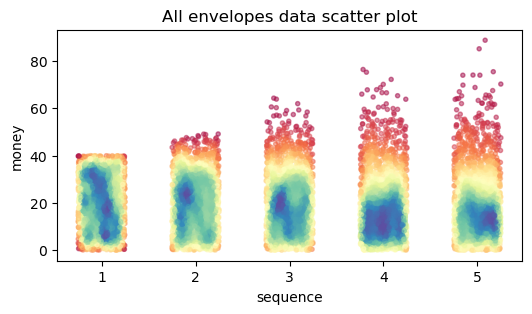

In [60]:
# giving envelopes to 5 people's simulations
from scipy.stats import gaussian_kde

# envelopes = generate_envelopes(100, 5, 20000)
envelopes = generate_envelopes(100, 5, 2000)

plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    # x = np.random.random(20000)
    x = np.random.random(2000)
    x = x / 2 + i + 0.75
    xy = np.vstack([x,envelopes[i]])
    z = gaussian_kde(xy)(xy) 
    plt.scatter(x, envelopes[i], c=z, marker='.', alpha=0.5, cmap='Spectral')
plt.title("All envelopes data scatter plot")
plt.show()

# about 16s

In the data simulation of the group of five, we found that the degree of dispersion was consistent with the distribution of our real data. There are no obvious difference of tendencies between each other except that there are more points here. The property we assumpted with only $100$ samples **(concluded as earlier gets stable, latter gets unstable)** is correct even under very very large samples!

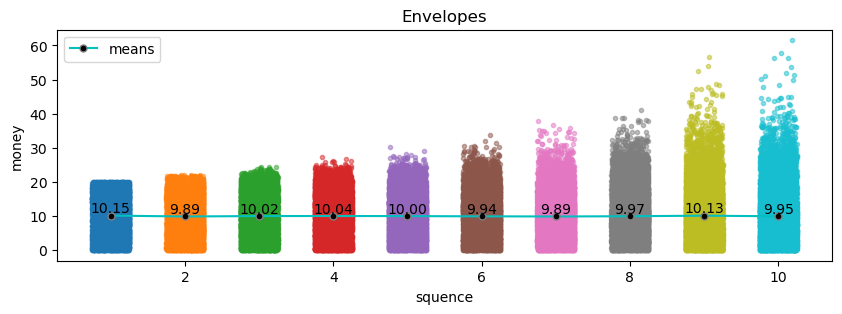

In [61]:
# giving envelopes to 10 people's simulations
# envelopes_10 = generate_envelopes(100, 10, 1000000)
# draw_envelope_graph(envelopes_10, 10, 1000000)

envelopes_10 = generate_envelopes(100, 10, 10000)
draw_envelope_graph(envelopes_10, 10, 10000)

# about 1 min

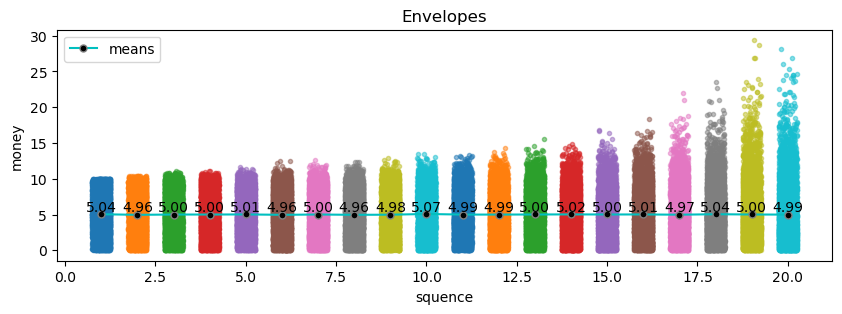

In [62]:
# giving envelopes to 20 people's simulations
# envelopes_20 = generate_envelopes(100, 20, 500000)
# draw_envelope_graph(envelopes_20, 20, 500000)
envelopes_20 = generate_envelopes(100, 20, 5000)
draw_envelope_graph(envelopes_20, 20, 5000)

# about 1 min

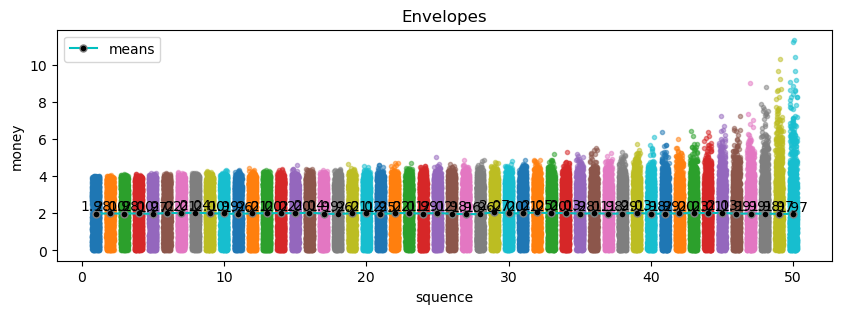

In [63]:
# giving envelopes to 50 people's simulations
# envelopes_50 = generate_envelopes(100, 50, 200000)
# draw_envelope_graph(envelopes_50, 50, 200000)
envelopes_50 = generate_envelopes(100, 50, 2000)
draw_envelope_graph(envelopes_50, 50, 2000)

# about 1 min

In the data simulation of the group of $10$, $20$ to $50$ people, the expectation was roughly the same, and they all showed that the farther the red envelope was snatched, the greater the degree of dispersion of the amount snatched. This property is the same with that in group of $5$ people.

Based on the study of the degree of dispersion, we visualize the variance of the amount of $10$ people, $20$ people and $50$ people, and confirm the fact that the higher the variance is.

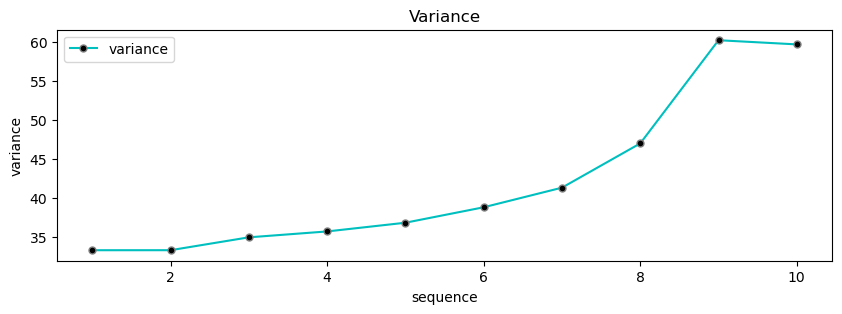

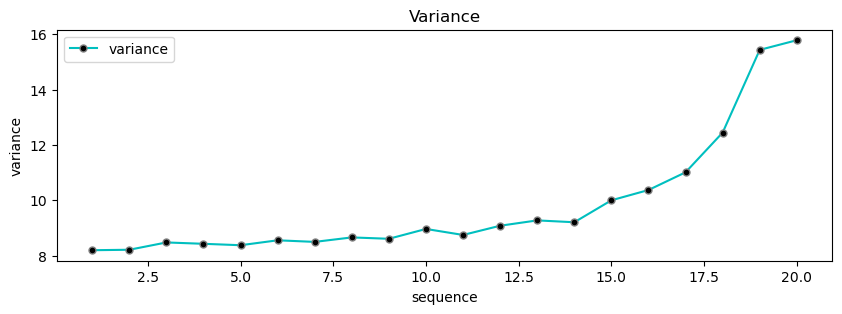

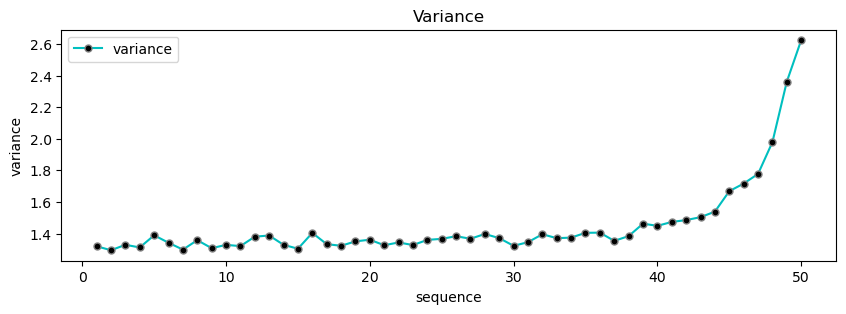

In [64]:
# plot variances
draw_variance(envelopes_10, 10)
draw_variance(envelopes_20, 20)
draw_variance(envelopes_50, 50)

As a conclusion of this part, we can not only validate the correctness of our model, but also find out that, no matter how many people, how much money is distributed, the expectation of everyone's money is the same, and that the one who grab latter has a higher variance and therefore has bigger chance of either receiving extremely large envelopes or extremely small envelopes.

## ***4.Decision-Making***

In this part, we want to find out the better or best strategy when we should start to grab an envelope. Particularly, we consider the best strategy as grabbing the biggest envelope each time.

First of all, we simulate the probability of grabbing the largest red envelope in different sequences:

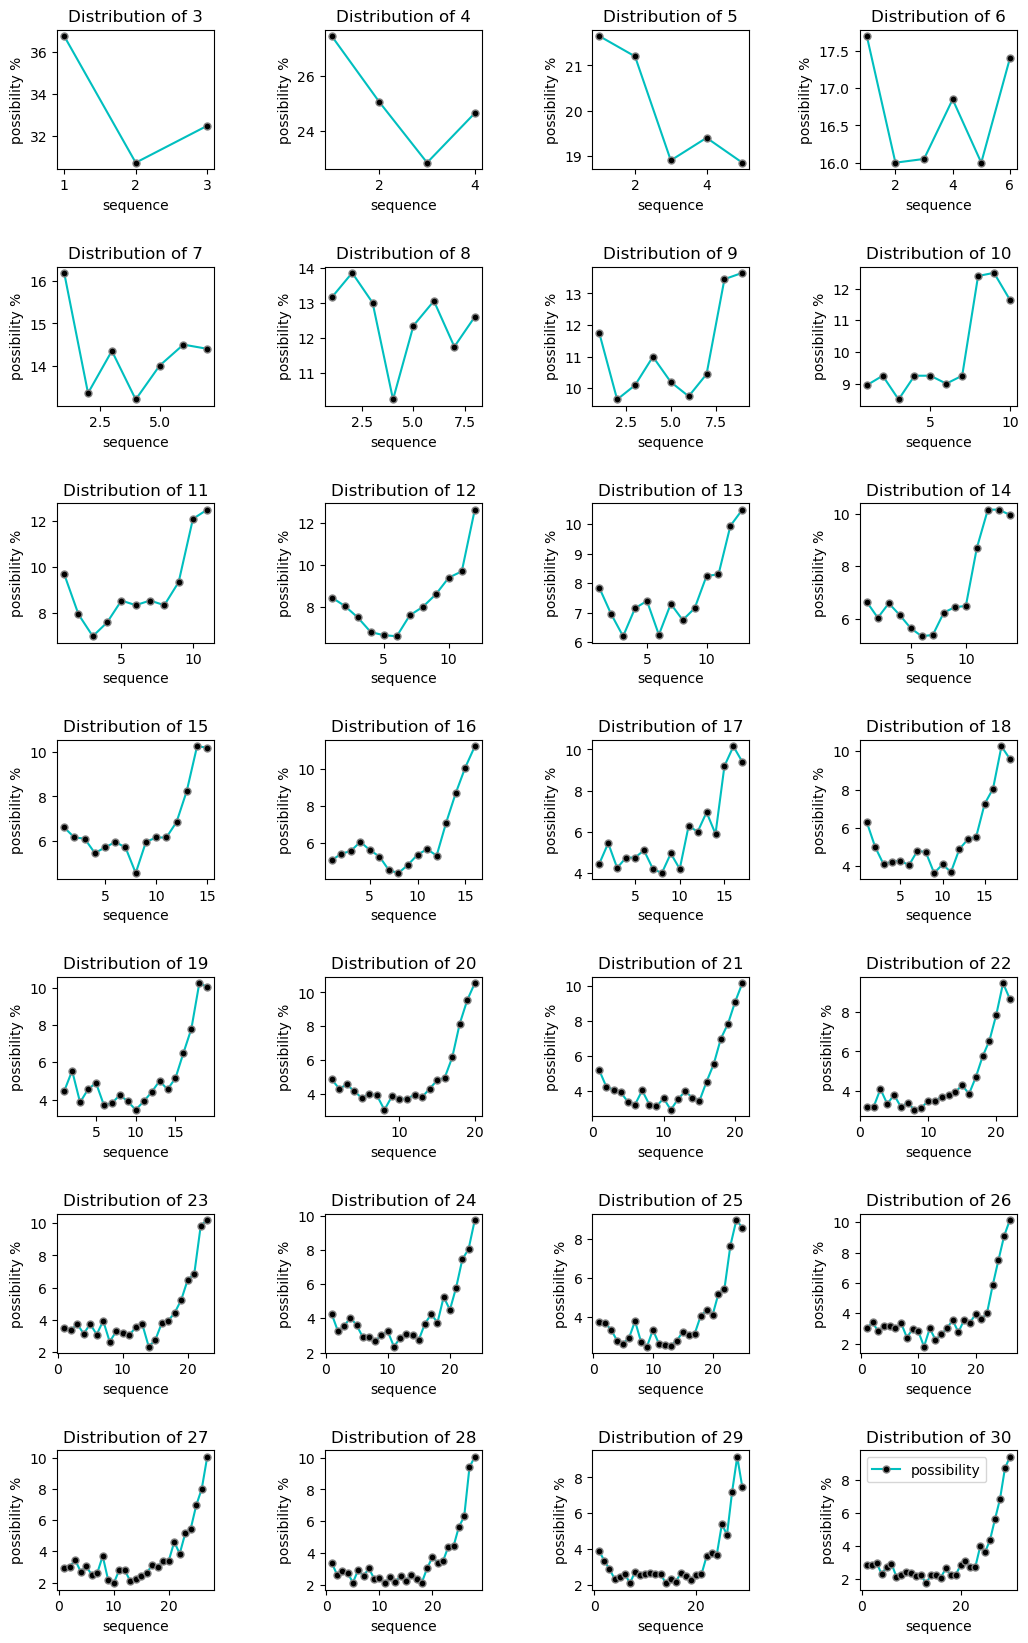

In [65]:
# find all distributions from n = 3 to n = 30
draw_distribution()

### From the simulation results, we can conclude that:
\
**(1).When there are few people(range from approximately $3$ to $7$), the first person to grab most likely to grab the largest red envelope.** \
\
**(2).When there are more people(more than $8$ or $9$), the last two people to grab are most likely to grab the largest red envelope.** 

However, since we've already known that the variance is larger and the probability of grabbing a small red envelope is also greater if we grab latter, we want to weigh the pros and cons and find a more secure scheme to grab the largest red envelope, so we conducted an analysis on how to grab the smallest red envelope.

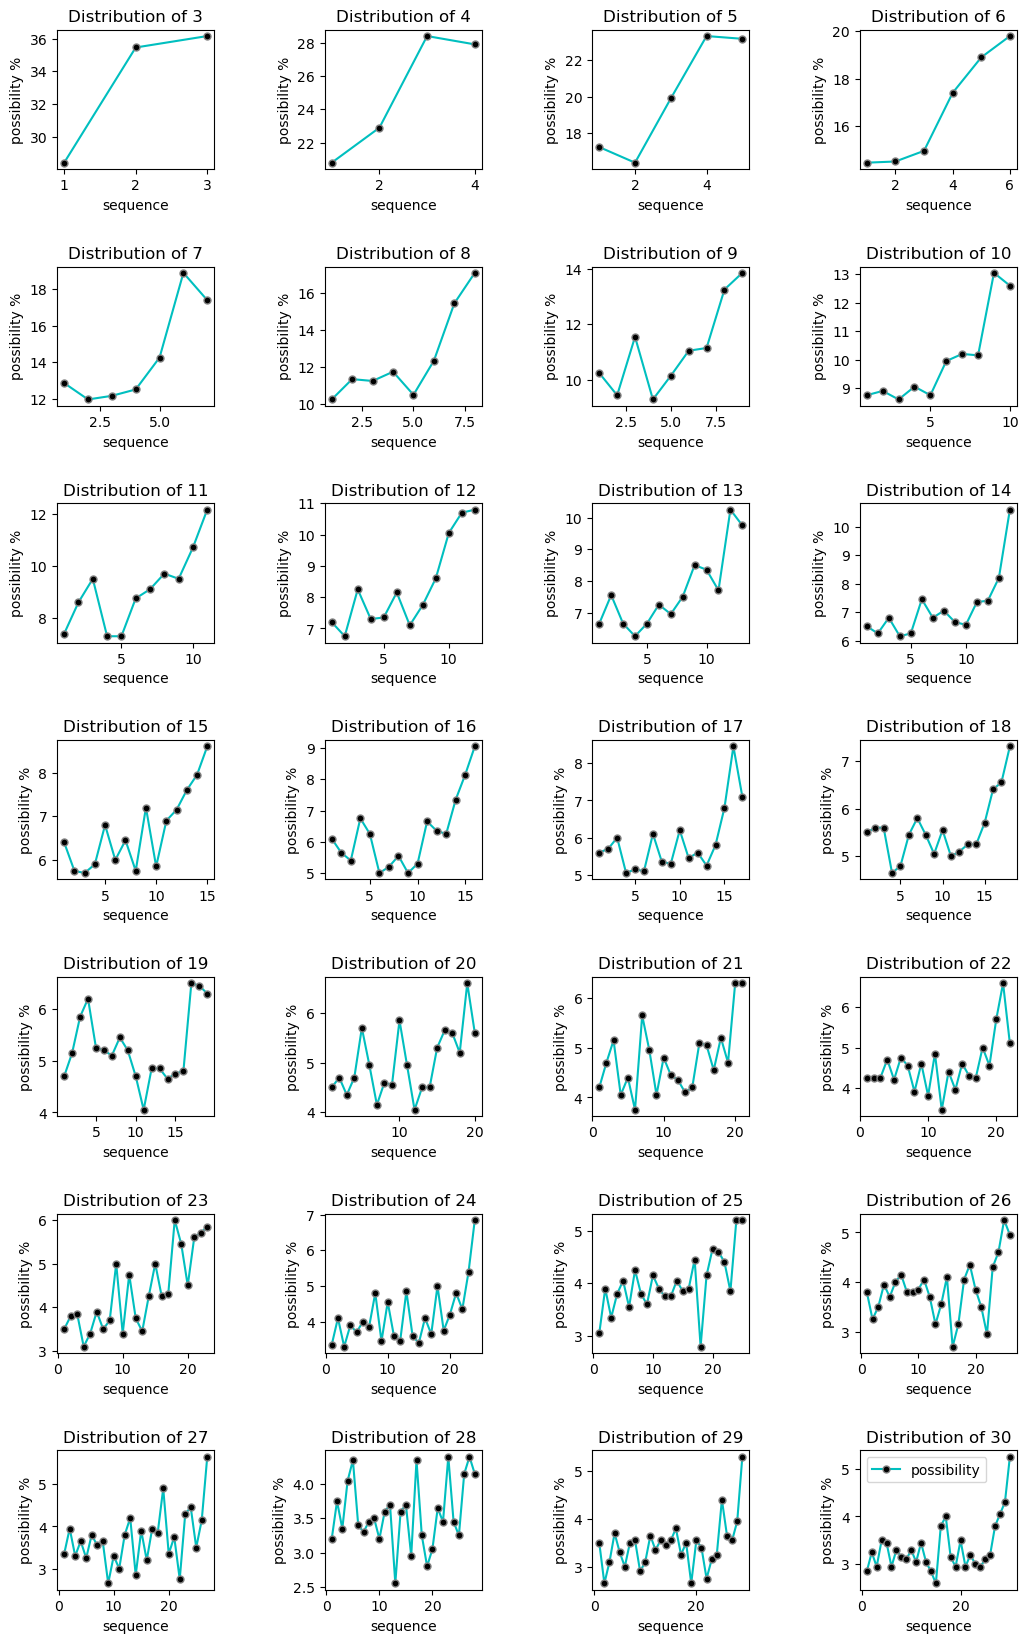

In [66]:
# find all distributions from n = 3 to n = 30
draw_distribution2()

### We can conclude from this diagramm that:
\
**(1).The overall trend is that the person who grabs earlier is less likely to grab the smallest red envelope.** \
\
**(2).When the number of people is small, the trend of data growth fluctuates less, and the probability of the last two people grabbing the smallest red envelope increases significantly.** \
\
**(3).When the number of people is large, the trend of data growth fluctuates greatly.**

### We then combine and consider the above two gramms together:
\
**(1).In the range of $3$-$7$ people(fewer people), the first person is least likely to grab the smallest envelope and most likely to grab the biggest envelope. Strategy here should be grab as early as possible if envelopes are distributed only to few people.**\
\
**(2).When there are more people(approximately $\geq 8$), there are both greater probabilities that the last second people grab either biggest or smallest envelope. However, The probability of grabbing the biggest rises more significantly than grabbing the smallest. At this time, it seems that the strategy here should be grabbing the latest.**\
\
**(3).But we still want to consider the reason of its "loss". Why does the latest grabber earn more probabilities here and since the amount are the same, who undertakes such price? Still under situation where there are many people, we find out that in the middle area, the probability of the two doesn't various much, but there're still some small differences at each point. We think that it's the summation of each difference in middle fields that contributes to the profit of the last grabber, and the more people there are, the larger middle field is, and therefore the greater profit the last grabber wins.**

We can also analyze the probability that the amount of the red envelope is greater than or equal to the median, to further verify our conclusion. We visualize the median amount of red packets captured as followings:

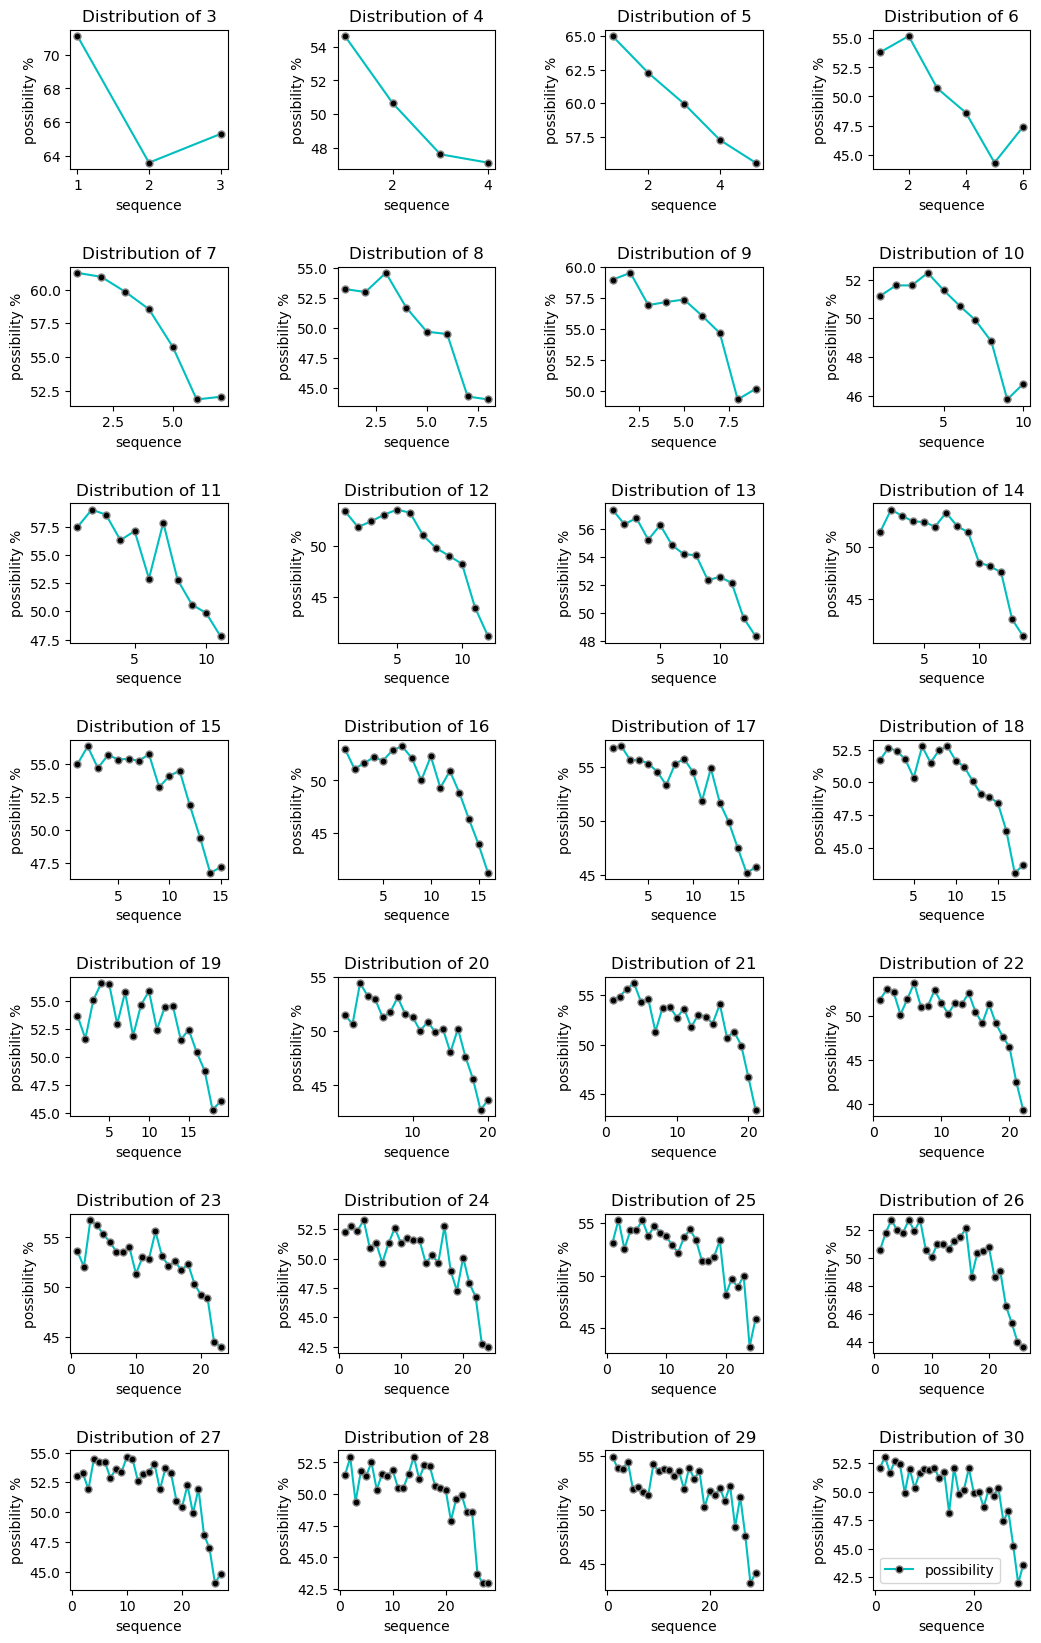

In [67]:
# find all distributions from n = 3 to n = 30
draw_distribution3()

### That one gets money more than the median number can be seen as secure expectation. We can conclude that:
\
**(1). In the range of $3-7$ people, the probability of grabbing a red packet with the amount greater than or equal to the median is greater, indicating that the first person to grab a red packet is more guaranteed to grab a large red packet (not necessarily the largest). At this point, we conducted a triple verification of the conclusion that the earlier to grab a red packet in the range of $3-7$ people, the better.** \
\
**(2). In the range of larger people, the probability of grabbing envelopes grater than median does not fall too much in middle fields, but falls in the last few drops sharply. Thus consider back to the previous conclusion, if you want to grab the largest red envelope under this situation, the price of it is that you not only must accept a greater probability of getting smaller red envelopes but also a greater probability of getting a red envelope below the median.** 

#### Combined with the above three analyses, we can develope the strategy of grabbing envelopes:
\
**(1). In the scope of the number of people who grab red envelopes is small, we should grab as early as possible, not only because we're likely to grab a bigger envelope, but also we might not be able to grab it if we were too slow.**\
\
**(2). In the scope of the number of people grabbing red envelopes:** \
\
**① If you're a gambler and want to take more risks to grab the biggest red envelope, just grab it the latest. Higher risk, higher profit.\
\
② If you're a person who want to enjoy the grabbing of envelopes and avoid the risk of receiving small envelopes, we recommend you to grab it early, since you're more likely to grab envelope greater than median level and less likely to be the unluckiest one to receive $0.01$, even though you're unable to grab large envelope here. Less risk, stable profit.**

## ***5.Further Explorations***

In the further explorations, we come up first with the idea of red envelope solitaire(or group note), which is known as **"红包接龙"**: In a particular group of people, everyone grabs an envelope and the one who receives most should gives out the envelope next. We simulate thousands of times(max $5000$) to find out how to be the final winner of this interesting game:

The settings here would be: everyone starts with $2000$ yuan and each envelope woths $20$ yuan. If any one has money less or equal to $0$, the game ends.

interrupting end of game with 2924 times in 3 people
interrupting end of game with 3960 times in 4 people
interrupting end of game with 4613 times in 5 people
interrupting end of game with 4627 times in 6 people
interrupting end of game with 4076 times in 11 people
interrupting end of game with 3433 times in 12 people
interrupting end of game with 2697 times in 13 people
interrupting end of game with 2794 times in 14 people
interrupting end of game with 1969 times in 15 people
interrupting end of game with 2635 times in 16 people
interrupting end of game with 2243 times in 17 people
interrupting end of game with 2244 times in 18 people
interrupting end of game with 2348 times in 19 people
interrupting end of game with 2326 times in 20 people
interrupting end of game with 2005 times in 21 people
interrupting end of game with 2201 times in 22 people
interrupting end of game with 1795 times in 23 people
interrupting end of game with 1838 times in 24 people
interrupting end of game with 21

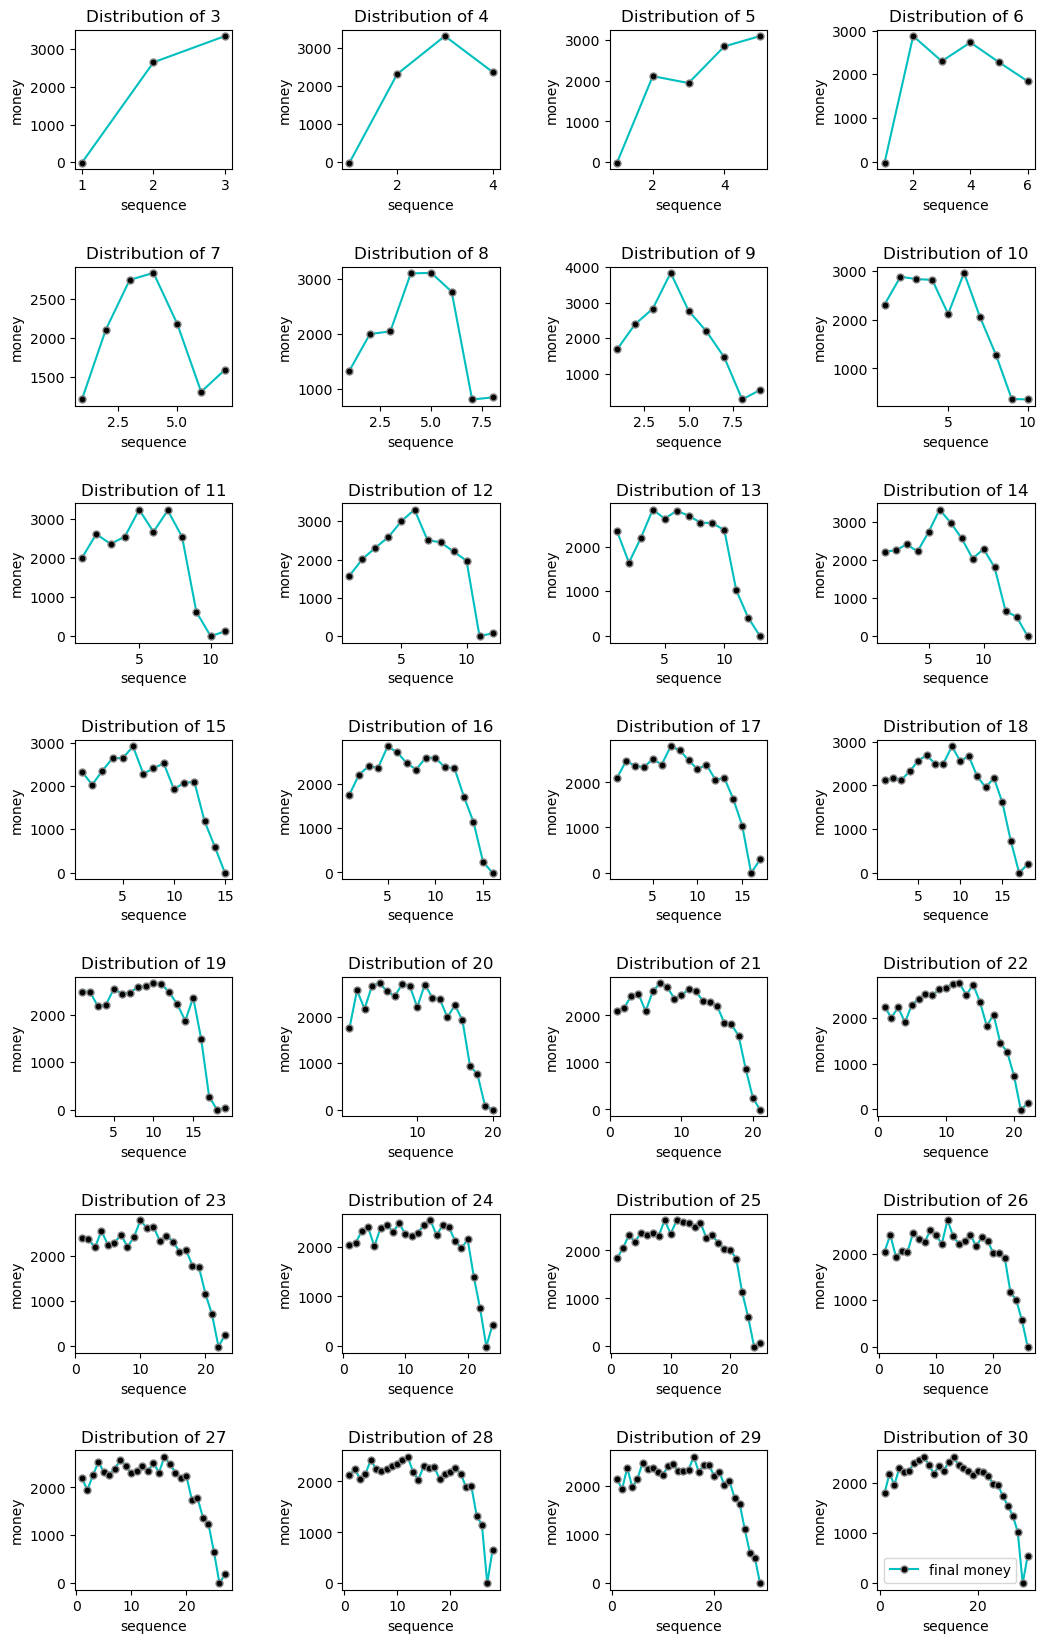

In [68]:
envelope_group_note()

### The printing results are much easier to conclude here:
\
**(1) In a group less or equal to $6$ people, grab it the latest, and you would win the most.**\
\
**(2) In a group with $\geq 7$ people, grab the envelopes in middle field. If it's hard to do it, just simply never grab it in the latest sequence. We can easily see that no matter how many people a group has, the latest grabbers are always the unluckiest ones.**\
\
This conclusion is also very straight-forward. As what we've concluded in last part, when there're few people, the first grabber would send the next envelope more likely, while the last grabber least likely to. Thus he laughs till the end. When there're too many people in a group, the last grabber has most probabilities to send the next envelope, and when he does not need to send(does not grab the biggest envelope), he only gets very few money as supply and would finally has no money.

Next, considering that if envelopes are given to different kinds of people, for example the children, they might be very unhappy if grabbing very small, so we can change our model to make it a user-specific one:

**User specific WRE mechanism 1**: We can make the bias of each random money smaller, in order to improve the fairness for children

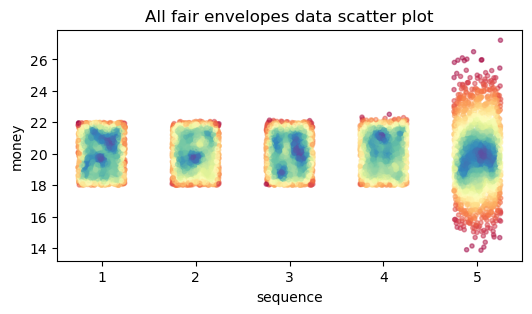

[19.995875 20.025995 19.98966  20.07889  19.90958 ]
[1.35116493 1.29928341 1.30574818 1.34462677 4.51958332]


In [69]:
fair_envelopes = generate_fair_envelopes(100, 5, 2000)

plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    x = np.random.random(2000)
    x = x / 2 + i + 0.75
    xy = np.vstack([x,fair_envelopes[i]])
    z = gaussian_kde(xy)(xy) 
    plt.scatter(x, fair_envelopes[i], c=z, marker='.', alpha=0.5, cmap='Spectral')
plt.title("All fair envelopes data scatter plot")
plt.show()
# print mean of envelope 0 to 4
print(np.mean(fair_envelopes, axis=1))
print(np.var(fair_envelopes, axis=1))

This method is to subtract the money generated by the original method and the average value, which effectively reduces the variance, but due to the accuracy problem, the variance of the last red envelope is still too large, so another idea is to set the amount of red envelope in advance to distribute

**User specific WRE mechanism 2**: We can add some noises at means of envelopes to make it look like randomly distributed but with very small variance.

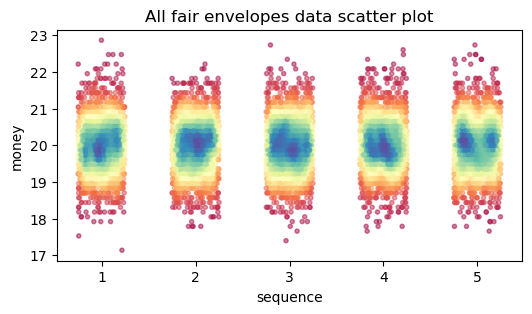

[19.99753 19.97881 19.99116 20.026   20.0065 ]
[0.545509   0.53375998 0.55314335 0.5380622  0.56573595]


In [70]:
fair_envelopes2 = generate_fair_envelopes2(100, 5, 2000)

plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    x = np.random.random(2000)
    x = x / 2 + i + 0.75
    xy = np.vstack([x,fair_envelopes2[i]])
    z = gaussian_kde(xy)(xy) 
    plt.scatter(x, fair_envelopes2[i], c=z, marker='.', alpha=0.5, cmap='Spectral')
plt.title("All fair envelopes data scatter plot")
plt.show()
# print mean of envelope 0 to 4
print(np.mean(fair_envelopes2, axis=1))
print(np.var(fair_envelopes2, axis=1))

This method is obviously more equal in distribution. We can also set the parameters of noise and iteration times to change the variance of this method. The current model is only an example to show its feasibility.

### ***Successive Fairness Red Envelopes***
Suppose there are $5$ people giving envelopes to each other, in order to prevent one always get least and get sad about it, we can increase the probability of who get minimum money and decrease the probability of getting the max money of money attribute.

We can setup an "unlucky threshold" and an "overlucky threshold". Let $C$ be the total amounts of money, and $N$ be the number of people in this group. So I will set the unlucky threshold $T_L$ and overlucky threshold $T_H$ as follows: 
$$
T_L = \frac{1}{2}\cdot\frac{C}{N}
$$
$$
T_H = 2\cdot\frac{C}{N}
$$
Anyone whose received money is **less** than $T_L$ will be counted as **unlucky**, and his probability of winning the money will go up to *105%* of the previous value. Anyone whose received money is **greater** than $T_H$ will be counted as **overlucky**, and his probability of winning the money will go down to $\frac{100}{105}$ of the previous value. Then their winning probability will be normalized to make sure the sum equals to $1$. 

Here's a result with $20$ samples. (Too much samples will make the graph unreadable)

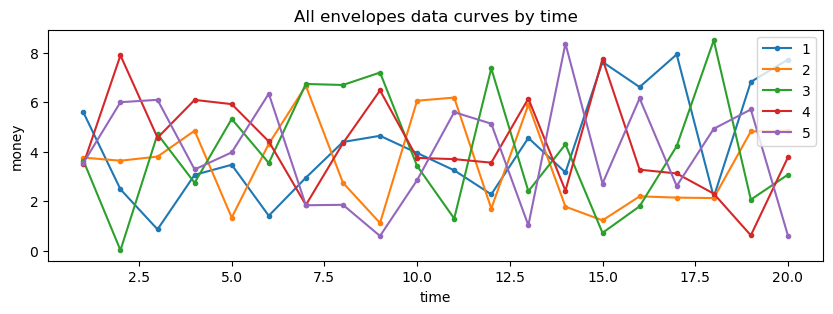

In [71]:
envelopes_fair = generate_fair_envelopes3(20, 5, 20)
draw_envelope_sequence(envelopes_fair, 5, 20)

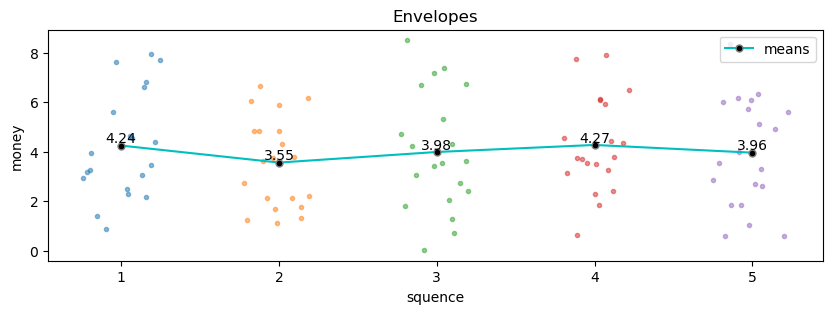

In [72]:
from envelope import draw_envelope_graph
draw_envelope_graph(envelopes_fair, 5, 20)

You can find out that for each curves (which representing a person), there is neither so much continuous low points and continuous high points. Their means are similar too. This can increase the fairness of the envelopes. 

$$\text{--- The End of Our Project ---}$$

Distribution of team members:
||秦朝|张明宇|韩承昊|
|---|---|---|---|
|学号|2022533137|2022533100||
|专业|CS|CS|EE|
|data processing|✔|✔||
|data analysing|✔|||
|story telling|✔|✔||
|model designing|✔|✔|✔|
|model validating|✔|||
|further exploration|✔||✔|